
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.18.2?urlpath=lab/tree/light_curve_simulation.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[light_curve_simulation.ipynb](../_static/notebooks/light_curve_simulation.ipynb) |
[light_curve_simulation.py](../_static/notebooks/light_curve_simulation.py)
</div>


# Binned light curve simulation and fitting

## Prerequisites:

- To understand how a single binned simulation works, please refer to [spectrum_simulation](spectrum_simulation.ipynb) [simulate_3d](simulate_3d.ipynb) for 1D and 3D simulations respectively.
- For details of light curve extraction using gammapy, refer to the two tutorials [light_curve](light_curve.ipynb) and [light_curve_flare](light_curve_flare.ipynb) 

## Context

Frequently, studies of variable sources (eg: decaying GRB light curves, AGN flares, etc) require time variable simulations. For most use cases, generating an event list is an overkill, and it suffices to use binned simulations using a temporal model.

**Objective: Simulate and fit a time decaying light curve of a source with CTA using the CTA 1DC response**

## Proposed approach:

We will simulate 10 spectral datasets within given time intervals (Good Time Intervals) following a given spectral (a power law) and temporal profile (an exponential decay, with a decay time of 6 hr ). These are then analysed using the light curve estimator to obtain flux points. Then, we re-fit the simulated datasets to reconstruct back the injected profiles.

In summary, necessary steps are:

- Choose observation parameters including a list of `gammapy.data.GTI`
- Define temporal and spectral models from :ref:model-gallery as per science case
- Perform the simulation (in 1D or 3D)
- Extract the light curve from the reduced dataset as shown in [light curve notebook](light_curve.ipynb)
- Optionaly, we show here how to fit the simulated datasets using a source model 


## Setup 

As usual, we'll start with some general imports...

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time
from regions import CircleSkyRegion

import logging

log = logging.getLogger(__name__)

And some gammapy specific imports

In [2]:
from gammapy.data import Observation
from gammapy.irf import load_cta_irfs
from gammapy.datasets import SpectrumDataset, Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpDecayTemporalModel,
    SkyModel,
)
from gammapy.maps import MapAxis
from gammapy.estimators import LightCurveEstimator
from gammapy.makers import SpectrumDatasetMaker
from gammapy.modeling import Fit

## Simulating a light curve

We will simulate 10 datasets using an `PowerLawSpectralModel` and a `ExpDecayTemporalModel`. The important thing to note here is how to attach a different `GTI` to each dataset.

In [3]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [4]:
# Reconstructed and true energy axis
center = SkyCoord(0.0, 0.0, unit="deg", frame="galactic")
energy_axis = MapAxis.from_edges(
    np.logspace(-0.5, 1.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.2, 2.0, 31), unit="TeV", name="energy_true", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=center, radius=on_region_radius)

In [5]:
# Pointing position
pointing = SkyCoord(0.5, 0.5, unit="deg", frame="galactic")

Note that observations are usually conducted in  Wobble mode, in which the source is not in the center of the camera. This allows to have a symmetrical sky position from which background can be estimated.

In [6]:
# Define the source model: A combination of spectral and temporal model

gti_t0 = Time("2020-03-01")
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
temporal_model = ExpDecayTemporalModel(t0="6 h", t_ref=gti_t0.mjd * u.d)

model_simu = SkyModel(
    spectral_model=spectral_model,
    temporal_model=temporal_model,
    name="model-simu",
)

/Users/adonath/software/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adonath/software/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [7]:
# Look at the model
model_simu.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,int64
index,3.0000e+00,,nan,nan,False,0.000e+00
amplitude,1.0000e-11,cm-2 s-1 TeV-1,nan,nan,False,0.000e+00
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
t0,2.5000e-01,d,nan,nan,False,0.000e+00
t_ref,5.8909e+04,d,nan,nan,True,0.000e+00


Now, define the start and observation livetime wrt to the reference time, `gti_t0`

In [8]:
n_obs = 10
tstart = [1, 2, 3, 5, 8, 10, 20, 22, 23, 24] * u.h
lvtm = [55, 25, 26, 40, 40, 50, 40, 52, 43, 47] * u.min

Now perform the simulations

In [9]:
datasets = Datasets()

empty = SpectrumDataset.create(
    e_reco=energy_axis, e_true=energy_axis_true, region=on_region, name="empty"
)

maker = SpectrumDatasetMaker(selection=["exposure", "background", "edisp"])

for idx in range(n_obs):
    obs = Observation.create(
        pointing=pointing,
        livetime=lvtm[idx],
        tstart=tstart[idx],
        irfs=irfs,
        reference_time=gti_t0,
        obs_id=idx,
    )
    empty_i = empty.copy(name=f"dataset-{idx}")
    dataset = maker.run(empty_i, obs)
    dataset.models = model_simu
    dataset.fake()
    datasets.append(dataset)

The reduced datasets have been successfully simulated. Let's take a quick look into our datasets.

In [10]:
datasets.info_table()

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str9,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
dataset-0,869,20.30377174963533,848.6962282503647,69.50876134726006,825.925411153998,20.30377174963533,805.6216394043627,216137902.05823946,16025275854.086987,3299.999999999999,3299.999999999999,0.2633333333333334,0.006152658105950102,0.2571806752273833,9,9,cash,-7101.052972215686
dataset-1,349,9.228987158925152,339.7710128410748,43.082459985513815,332.14278827322767,9.228987158925152,322.91380111430254,98244500.93556342,7284216297.312269,1500.0,1500.0,0.23266666666666666,0.006152658105950101,0.22651400856071655,9,9,cash,-2186.516332896211
dataset-2,310,9.598146645282158,300.40185335471784,39.41697228422083,293.48250627100055,9.598146645282158,283.8843596257184,102174280.97298595,7575584949.20476,1560.0,1560.0,0.1987179487179487,0.006152658105950101,0.19256529061199862,9,9,cash,-1870.045198619309
dataset-3,311,14.766379454280242,296.23362054571976,36.09765120832382,321.772945022102,14.766379454280242,307.0065655678218,157191201.49690145,11654746075.69963,2400.0,2400.0,0.12958333333333333,0.006152658105950101,0.12343067522738323,9,9,cash,-1898.139192754432
dataset-4,170,14.76637945428022,155.2336205457198,22.81017817853078,200.97527420424075,14.76637945428022,186.2088947499605,157191201.4969012,11654746075.699614,2399.9999999999964,2399.9999999999964,0.07083333333333344,0.0061526581059501,0.06468067522738334,9,9,cash,-863.9209374008468
dataset-5,186,18.457974317850304,167.5420256821497,22.898231747848016,182.9858048173724,18.457974317850304,164.52783049952214,196489001.87112683,14568432594.624538,3000.0,3000.0,0.062,0.006152658105950101,0.0558473418940499,9,9,cash,-924.3987439981889
dataset-6,43,14.766379454280242,28.23362054571976,5.954293927723896,39.96701296644291,14.766379454280242,25.20063351216266,157191201.49690145,11654746075.69963,2400.0,2400.0,0.017916666666666668,0.006152658105950101,0.011764008560716566,9,9,cash,-97.2488965215336
dataset-7,50,19.196293290564316,30.803706709435684,5.841503818597208,42.290648816036764,19.196293290564316,23.094355525472444,204348561.9459719,15151169898.40952,3120.0,3120.0,0.016025641025641024,0.006152658105950101,0.009872982919690925,9,9,cash,-127.59717680800631


## Extract the lightcurve

This section uses standard light curve estimation tools for a 1D extraction. Only a spectral model needs to be defined in this case. Since the estimator returns the integrated flux separately for each time bin, the temporal model need not be accounted for at this stage.

In [11]:
# Define the model:
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_fit = SkyModel(spectral_model=spectral_model, name="model-fit")

In [12]:
# Attach model to each dataset
for dataset in datasets:
    dataset.models = model_fit

In [13]:
%%time
lc_maker_1d = LightCurveEstimator(
    energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]],
    source="model-fit",
)
lc_1d = lc_maker_1d.run(datasets)

CPU times: user 4.57 s, sys: 61.1 ms, total: 4.63 s
Wall time: 4.84 s


In [14]:
lc_1d.table["is_ul"] = lc_1d.table["ts"] < 1

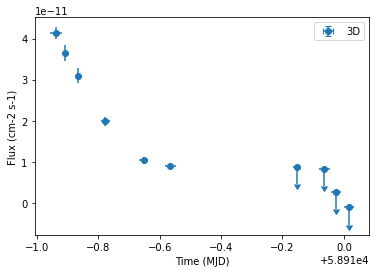

In [15]:
ax = lc_1d.plot(marker="o", label="3D")

We have the reconstructed lightcurve at this point. Further standard analyis might involve modeling the temporal profiles with an analytical or theoretical model. You may do this using your favourite fitting package, one possible option being `curve_fit` inside `scipy.optimize`.

In the next section, we show how to simulatenously fit the all datasets using a given temporal model. This does a joint fitting across the different datasets, while simultaneously miniminsing across the temporal model parameters as well. We will fit the amplitude, spectral index and the decay time scale. Note that `t_ref` should be fixed by default for the `ExpDecayTemporalModel`. 

For modelling and fitting more complex flares, you should attach the relevant model to each group of `datasets`. The paramters of a model in a given group of dataset will be tied. For more details on joint fitting in gammapy, see [here](modeling.ipynb).

## Fit the datasets

In [16]:
# Define the model:
spectral_model1 = PowerLawSpectralModel(
    index=2.0, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
temporal_model1 = ExpDecayTemporalModel(t0="10 h", t_ref=gti_t0.mjd * u.d)

model = SkyModel(
    spectral_model=spectral_model1,
    temporal_model=temporal_model1,
    name="model-test",
)

/Users/adonath/software/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adonath/software/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [17]:
model.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,int64
index,2.0000e+00,,nan,nan,False,0.000e+00
amplitude,1.0000e-12,cm-2 s-1 TeV-1,nan,nan,False,0.000e+00
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
t0,4.1667e-01,d,nan,nan,False,0.000e+00
t_ref,5.8909e+04,d,nan,nan,True,0.000e+00


In [18]:
datasets.models = model

In [19]:
%%time
# Do a joint fit
fit = Fit(datasets)
result = fit.run()

CPU times: user 8.55 s, sys: 65.2 ms, total: 8.62 s
Wall time: 9.08 s


In [20]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.9963e+00,,nan,nan,False,3.149e-02
amplitude,1.0587e-11,cm-2 s-1 TeV-1,nan,nan,False,3.676e-13
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
t0,2.3676e-01,d,nan,nan,False,8.191e-03
t_ref,5.8909e+04,d,nan,nan,True,0.000e+00


We see that the fitted parameters match well with the simulated ones!

## Exercises

1. Re-do the analysis with `MapDataset` instead of `SpectralDataset`
2. Model the flare of PKS 2155-304 which you obtained using the [light curve flare tutorial](light_curve_flare.ipynb). Use a combination of a Gaussian and Exponential flare profiles, and fit using `scipy.optimize.curve_fit`
3. Do a joint fitting of the datasets.